In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [89]:
pd.set_option('display.min_rows', 100)

In [90]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0.1, 0.8, n))

In [91]:
with open("metrics_8p_retry.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={"labels.status": "status", "labels.provider": "provider"}, inplace=True)
points["end"] = points['start'] + points['duration']

In [92]:
success = points[points["status"] == "success"].sort_values(by='start')
confirmed = points[points["status"] == "confirmed"].sort_values(by='start')

In [93]:
success.shape

(712, 7)

In [94]:
success["duration"].median()

2233.3501319885254

In [95]:
confirmed["duration"].median()

11519.979588985443

In [96]:
# epoches = dict()
# for (pv, group) in success.groupby('provider'):
#     group = group.copy()
#     td = group["start"].diff()
#     threshold = 90000 # minute
#     group["epoch"] = (td > threshold).cumsum()
    
#     epoches_pv = group.groupby("epoch").agg(start=('start', 'min'), end=('end', 'max')).reset_index()
#     epoches_pv["duration"] = epoches_pv["end"] - epoches_pv["start"]
#     epoches[pv] = epoches_pv

# epoches = epoches["PV2"]

epoches = success[["start", "end"]].copy()
epoches.sort_values(by="start", inplace=True)
td = epoches["start"].diff()
threshold = 45000 
epoches["epoch"] = (td > threshold).cumsum()

epoches = epoches.groupby("epoch").agg(start=('start', 'min'), end=('start', 'max')).reset_index()
epoches["end"] = epoches["end"] + success["duration"].median()
epoches["duration"] = epoches["end"] - epoches["start"]
epoches = epoches[epoches["duration"] > 120_000]

In [97]:
epoches

,epoch,start,end,duration
0,0,2.562696e+05,5.561761e+05,299906.580491
1,1,6.418284e+05,8.749154e+05,233086.943658
2,2,9.484167e+05,1.159607e+06,211190.790808
3,3,1.235328e+06,1.477120e+06,241791.156313
4,4,1.552210e+06,1.763019e+06,210808.863677


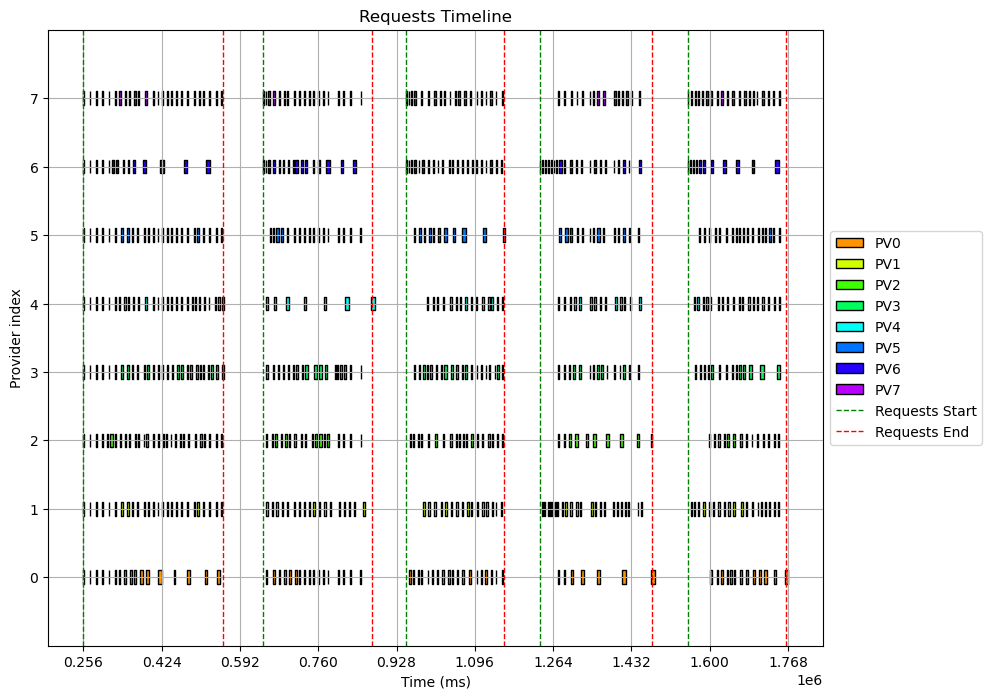

In [98]:
count = len(success['provider'].unique())
plt.figure(figsize=(10, count))
cmap = get_cmap(count)

# for i, (pv, group) in enumerate(confirmed.groupby('provider')):
#     data = list(zip(group['start'], group['duration']))
#     plt.broken_barh(data, (i - 0.05, 0.1), edgecolor=cmap[i], facecolor="black", label=pv)

for i, (pv, group) in enumerate(success.groupby('provider')):
    data = list(zip(group['start'], group['duration']))
    plt.broken_barh(data, (i-0.1, 0.2), edgecolor='black', facecolor=cmap[i], label=pv)

for _, row in epoches.iterrows():
    plt.axvline(x=row['start'], color='g', linestyle='--', linewidth=1, label='Requests Start' if _ == 0 else "")
    plt.axvline(x=row['end'], color='r', linestyle='--', linewidth=1, label='Requests End' if _ == 0 else "")

# Formatting
plt.xticks(np.linspace(success["start"].min(), success["end"].max(), 10))
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (ms)')
plt.ylabel('Provider index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

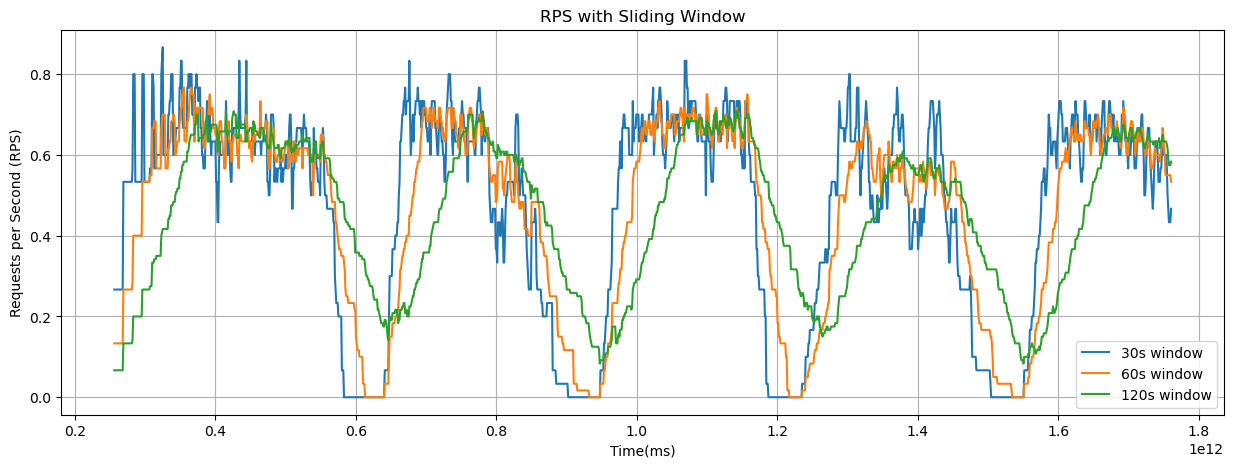

In [99]:
reqs = success[["start"]].copy()
reqs["start"] = pd.to_timedelta(reqs["start"], unit="ms")
reqs = reqs.groupby("start").size().to_frame(name='counts')

# Resample to 1-second frequency
resampled = reqs.resample('1S').count()

def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(30)
plot_window(60)
plot_window(120)
plt.xlabel('Time(ms)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
erps = []
for (i, epoch) in epoches.iterrows():
    count = len(success[(success["start"] > epoch["start"]) & (success["end"] < epoch["end"])])
    rps = count / epoch["duration"] * 1000
    erps.append(rps)
    print(rps)
pd.Series(erps).median()

0.6368649853807651
0.5491513080535858
0.6629076933913429
0.4838886656738209
0.5929541947131288


0.5929541947131288

Text(0, 0.5, 'RPS')

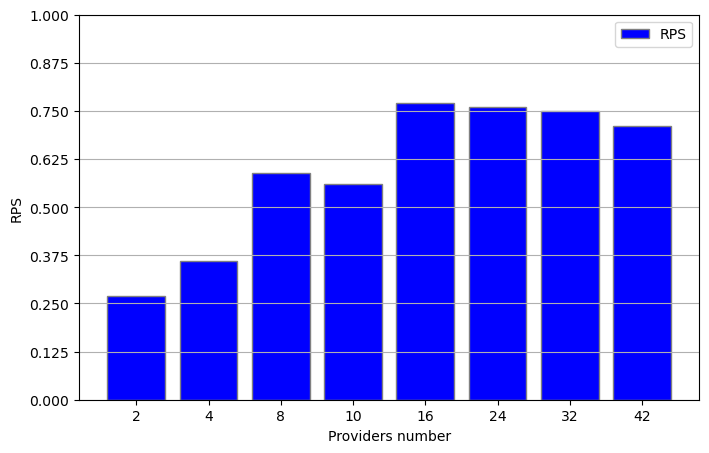

In [103]:
providers = ["2", "4", "8", "10", "16", "24", "32", "42"]
providers_rps = [0.27, 0.36, 0.59, 0.56, 0.77, 0.76, 0.75, 0.71]
barWidth = 0.8

plt.figure(figsize=(len(providers), 5))

n_providers = len(providers)
rps_x = np.arange(n_providers)

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='RPS')

plt.legend()
plt.grid(True, axis="y")
plt.xticks(range(n_providers), providers)
plt.yticks(np.linspace(0, 1, 9))
plt.xlabel("Providers number")
plt.ylabel("RPS")

Text(0, 0.5, 'RPS')

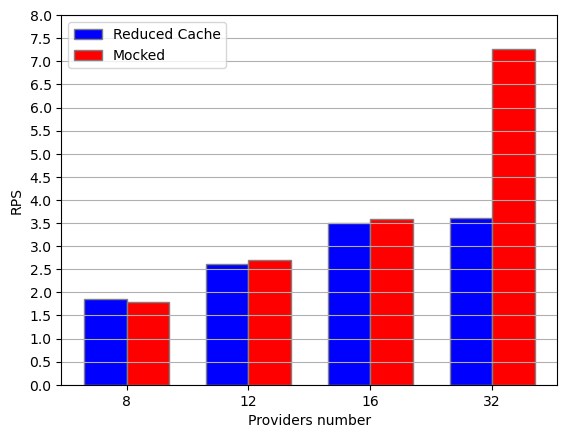

In [102]:
providers = ["8", "12", "16", "32"]
providers_rps = [1.85, 2.62, 3.5, 3.61]
providers_m_rps = [1.79, 2.70, 3.58, 7.26]

n_providers = len(providers)
barWidth = 0.35
rps_x = np.arange(n_providers)
rps_m_x = [x + barWidth for x in rps_x]

plt.bar(rps_x, providers_rps, color='blue', width=barWidth, edgecolor='grey', label='Reduced Cache')
plt.bar(rps_m_x, providers_m_rps, color='red', width=barWidth, edgecolor='grey', label='Mocked')

plt.legend()
plt.grid(True, axis="y")
plt.xticks([r + barWidth/2 for r in range(n_providers)], providers)
plt.yticks(np.linspace(0, 8, 17))
plt.xlabel("Providers number")
plt.ylabel("RPS")

Text(0, 0.5, 'Frequency')

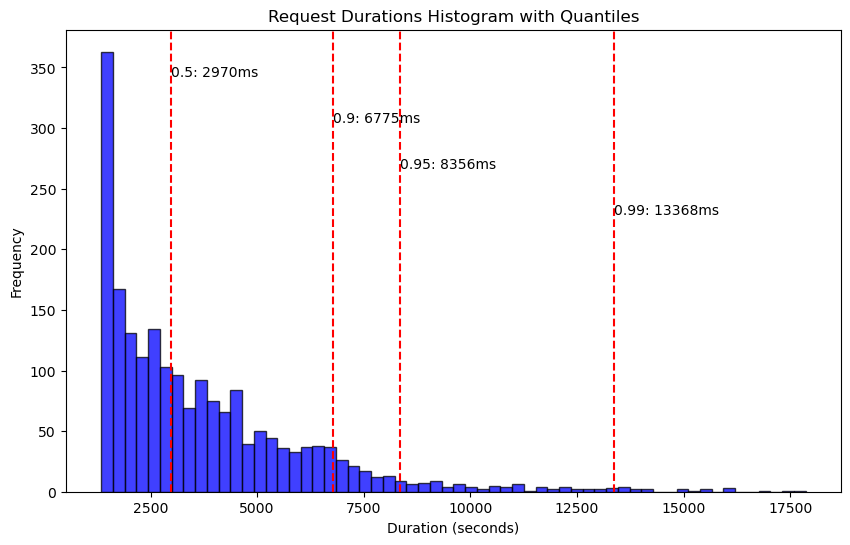

In [19]:
q = [0.5, 0.90, 0.95, 0.99]
quantiles = success['duration'].quantile(q)

# Plot histogram
plt.figure(figsize=(10, 6))
#space = np.logspace(np.log10(success['duration'].min()), np.log10(success['duration'].max()), 100)
#n, bins, patches = plt.hist(success['duration'], bins=space, alpha=0.75, color='blue', edgecolor='black')
n, bins, patches = plt.hist(success['duration'], bins=60, alpha=0.75, color='blue', edgecolor='black')

#plt.xscale('log')  # Set x-axis to log scale

# Annotate quantiles
for i, quantile in enumerate(quantiles):
    plt.axvline(x=quantile, color='r', linestyle='--')
    plt.text(quantile, plt.ylim()[1]*(9 - i)*0.1, f'{q[i]}: {quantile:.0f}ms', horizontalalignment='left', color='black')

plt.title('Request Durations Histogram with Quantiles')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')